In [280]:
#-----> INSTALACION DE TECNOLOGIA A UTILIZAR
#%pip install selenium #--
#%pip install praw #--
#%pip install nltk # --
#%pip install spacy
#%pip install tensorflow
#%pip install matplotlib

In [281]:
#----- IMPORTACIONES ---------

#Componente de selinum para interactuar con el navegador
from selenium import webdriver as web #---
#Importacion de la biblioteca Python Reddit API Wrapper
#Provee acceso de manera sencilla a la API de Reddit
import praw #---
import pandas as pd # --
import nltk #--
import string # --
import spacy #--
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Input
import matplotlib.pyplot as plt
import numpy
from collections import Counter

In [282]:
#---------> RECURSOS SPACY
from spacy.cli import download
#download("es_core_news_sm")

nlp = spacy.load("es_core_news_sm")


In [283]:
#-------> RECURSOS DE NLTK
#nltk.download('punkt')        # Tokenización
#nltk.download('stopwords')    # Stopwords
#nltk.download('wordnet')      # Lematización
#nltk.download('vader_lexicon') #Etiquetado


In [284]:
#------- IMPORTACIONES NLTK ----------
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

In [285]:
# ------------- SELENIUM ------------- 

#Inicializar una sesion en Edge mediente opciones basicas
options = web.EdgeOptions()
options.add_argument("--start-maximized") #Se ejecuta sin abrir edge
options.add_experimental_option("detach", True)
#Configura el servicio de selenium --> indica ruta del driver
service = web.EdgeService("./edgedriver_win64/msedgedriver.exe") 
#Especifica la ruta de un subreddit --> Comunidad de nicho en reddit
url = "https://www.reddit.com/r/technology/"

#Inicializa el navegador con el servicio y opciones dadas
driver = web.Edge(service=service, options = options)
#Abre la pagina web indicada
driver.get(url)

In [286]:
# ------------ CLIENTE DE REDDIT ------------

#Credenciales para consumir la API de reddit
#Configuracion de un cliente de reddit --> utiliza la bibliteca PRAW
reddit = praw.Reddit(
  client_id = "080XrJH4Q_dMV39t2FWsrQ", #
  client_secret = "UwMgiM1oJufrxgBB_OynJA_b0hoRvQ",
  user_agent = "AnyApp/1.0 by Angel"
)

In [287]:
# ----------- ACCESO AL SUBREDDIT ---------

#Accede al subreddit tecnhology
subreddit = reddit.subreddit("technology") 
#Obtiene los dos post mas votados de la ultima semana. 
top_posts = subreddit.top(time_filter="week", limit = 3) 

In [288]:
# ----------- CREAR DATAFRAME ----------

#Array para guardar comentarios
comments_list  = []

for post in top_posts: # Itera sobre los post indicados
  submission = reddit.submission(id=post.id)  # Acceder al post por ID
  submission.comments.replace_more(limit=None)  # Expande todos los comentarios
  for comment in submission.comments.list(): #Accede a los comentarios del post
    comments_list.append(comment.body) #Guarda los comentarios en un array

#Crea el DataFrame con los comentarios obtenidos con la columna Comments
df = pd.DataFrame(comments_list, columns=["Comment"])

In [289]:
#------ Cierra sesion del navegador
driver.quit()

In [290]:
# -------------- PROCESAMIENTO DE TEXTO ------------- 

stop_words = set(stopwords.words('spanish'))

# Realiza un proceso de tokenizacion
#Los resultados los agrega en una nueva columna --> Tokens
df["Tokens"] = df ["Comment"].apply(
  lambda x: [
              token.lemma_  # Obtén el lema del token
              for token in nlp(x.lower())  # Procesa el texto con spaCy
              if token.text not in string.punctuation # retira signos de puntuacion
              and token.text not in stop_words  # Filtra stopwords
              and not token.is_space  # Ignora espacios en blanco
            ] 
)

In [291]:
#------ TOKENS A TEXTO PLANO -------

df["Text_Processed"] = df["Tokens"].apply(lambda tokens:" ".join(tokens))
# ['Hola','mundo'] ---> "Hola mundo"

In [292]:
#----- Vectorización de los datos con TF-IDF

#Convierte el conjunto de texto en una matriz de caracteristicas numericas
tfidf = TfidfVectorizer(max_features=5000)  # Usa 5000 características como límite
X = tfidf.fit_transform(df["Text_Processed"]).toarray()  # Vectoriza el texto


In [293]:
#-------> Etiquetado con VADER --> NLTK Modelo preentrenado
#Inicializa el analizador
sia = SentimentIntensityAnalyzer()

#Funcion ---> Asignacion de etiquetas basadas en sentimientos
def assign_label(comment):
  sentiment_score = sia.polarity_scores(comment)['compound']
  return 1 if sentiment_score > 0 else 0  # Positivo si el sentimiento es mayor a 0, negativo si no
# {'neg': 0.0, 'neu': 0.34, 'pos': 0.66, 'compound': 0.802}

#Coloca una columna de etiquetado al dataframe --> Realiza la clasificacion
df["Label"] = df["Comment"].apply(assign_label)


In [294]:
# ------- Division entre datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
  X,  # Representacion TF-IDF de los comentarios
  df["Label"],  # Etiqueas asociadas a cada comentario de la matriz
  test_size=0.2, #20% es del conjunto de prueba
  random_state=42, #Semilla aleatoria para que la división sea reproducible
  stratify=df["Label"]  # Asegura proporción balanceada entre conjuntos
)

In [295]:
# ------------ Conversion serie PANDAS --> NUMPY
if isinstance(y_train, pd.Series):
  y_train = y_train.to_numpy()

# ----- Formato compatible para el entrenamiento y evaluacion del modelo

In [296]:
#-------- Calcular proporciones de clase -- evista desvlances de clase

# Cuenta cantidad de ocurrencias 
class_counts = Counter(y_train) 

# Total de ejemplos
total_samples = len(y_train) #Determina la proporción de cada clase 

# Calcular los pesos de las clases
class_weights = { #Diccionario
    cls: total_samples / (2 * count) 
    for cls, count in class_counts.items()
}

#Indica al modelo que le dé más imporrancia a las clases con menos datos. 

In [297]:
#--------- Escala de datos

#Coloca los datos en el mismo rango 

scaler = StandardScaler()

# Escalar datos de entrenamiento y prueba
X_train = scaler.fit_transform(X_train)  # Ajusta el escalador y transforma los datos de entrenamiento
X_test = scaler.transform(X_test)  # Transforma los datos de prueba con el escalador ajustado

In [298]:
#------ CONSTRUCCION DEL MODELO
#Define  el modelo
#relu = PERMITE APRENDER RELACIONES COMPLEJAS --> No lineal
model = Sequential([ #Las capas seran aplicadas una tras otra
  Input(shape=(X_train.shape[1],)), #Numero de columnas de datos de entrada
    Dense(32, activation="relu"), #Capa conectada con 32 neuronas 
    BatchNormalization(), #Normaliza las salidas
    Dropout(0.8), #Prevenir sobre ajuste - desactiva 80% de las neuronas
    Dense(16, activation="relu"), #Capa con 16 neuronas
    BatchNormalization(),
    Dropout(0.8),
    Dense(1, activation="sigmoid") #Capa de salida con 1 neurona
    #Sigmoid -> convierte la salida entre 0 y 1 
])

#1er capa = Aprende caracteristicas simples
#2da capa = capturan relaciones mas complejas 

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [299]:
# -------> EARLY STOPPING
# 2 epocas limite. Si despues de dos no mejora, se detiene
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
# True -- restore: Toma el estado en el que obtuvo mejor rendimiento
#Durante el entramiento lo detiene si deja de mejorar despues de un

In [300]:
#------------- Entrenamiento del modelo

# Entrenar el modelo
history = model.fit(
  X_train, y_train,  # Datos de entrenamiento
  #Evaluan el desempeño del modelo despues de la epoca
  validation_split=0.2,  # Usar una fracción de entrenamiento para validación
  epochs=20,  # Numero de iteraciones completas sobre los datos
  batch_size=32,  # Numero de muestras por lote
  class_weight=class_weights, #Ajusta importancia dada para los desvalances
  callbacks=[early_stopping] #Detiene el modelo de manera automatica si deja de mejorar
)

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4826 - loss: 1.1539 - val_accuracy: 0.5166 - val_loss: 0.7125
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5055 - loss: 0.9980 - val_accuracy: 0.5414 - val_loss: 0.6913
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5348 - loss: 0.8581 - val_accuracy: 0.5652 - val_loss: 0.6889
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5415 - loss: 0.8092 - val_accuracy: 0.5787 - val_loss: 0.6830
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5503 - loss: 0.7416 - val_accuracy: 0.5911 - val_loss: 0.6780
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5547 - loss: 0.7097 - val_accuracy: 0.6097 - val_loss: 0.6769
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5772 - loss: 0.7003 - val_accuracy: 0.6025 - val_loss: 0.6756
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5719 - loss: 0.6734 - val_accuracy: 0.

In [301]:
#---------------- Predicciones en el conjunto de prueba

#Genera predicciones del modelo de prueba
y_pred = (model.predict(X_test) > 0.4).astype("int32")
# Mayor a 0.4 (positivo) menor (negativo) --> comentarios

# Imprimir el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred)) #Genera infome con metricas de desempeño

#Presicion ---> Predicciones positivas correctas
#Recall ----> Ejemplos positivos identificados correctamente

#F1 Score ---> Promedio entre pesicion y recall
#support ---> Numero total de ejemplos reales en cada clase

#Accuracy ---> precision global del modelo
#Macro ---> Promedio entre las metricas de todas las clases (sin tamaño)
#Wight ---> promedio ponderado tomando en cuenta el tamaño de la clase

# Imprimir la matriz de confusión
#Muestra como se distributen las prediciones del modelo

#[TP | FP] #Correcto positivo | incorrecto positivo
#[FN | TN] #Incorrecto negativo | Correcto negativo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.47      0.60       696
           1       0.55      0.88      0.68       511

    accuracy                           0.64      1207
   macro avg       0.70      0.68      0.64      1207
weighted avg       0.72      0.64      0.63      1207

Matriz de confusión:
[[324 372]
 [ 59 452]]


**Concluclision general**

El modelo logró una precisión global del 66%, indicando que predijo correctamente el 66% de los ejemplos en el conjunto de prueba. 

In [302]:
#---------- EVALUACION DEL MODELO CON CONJUNTO DE PRUEBA
# Convertir y_test a un array NumPy si es una serie de pandas 
#Asegura compatibilidad entre datos
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

# Evaluar el modelo
#Calcula la perdida, y le presicion del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en prueba: {test_loss:.4f}") #Error promedio en los datos
print(f"Precisión en prueba: {test_accuracy:.4f}") # Predicciones correctas

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6625 - loss: 0.6129
Pérdida en prueba: 0.6118
Precisión en prueba: 0.6603


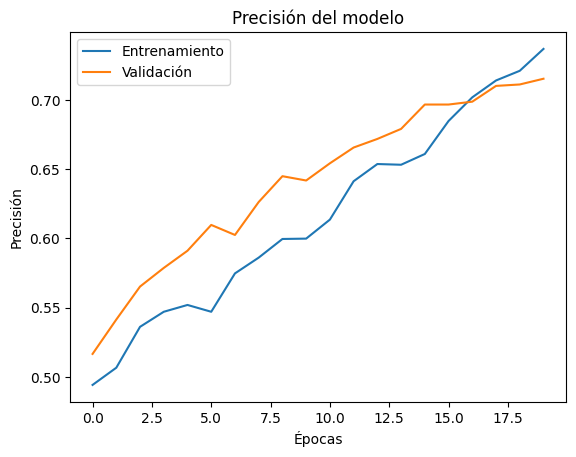

In [303]:
# ------- GRAFICA DE LOS RESULTADOS

# Graficar precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()



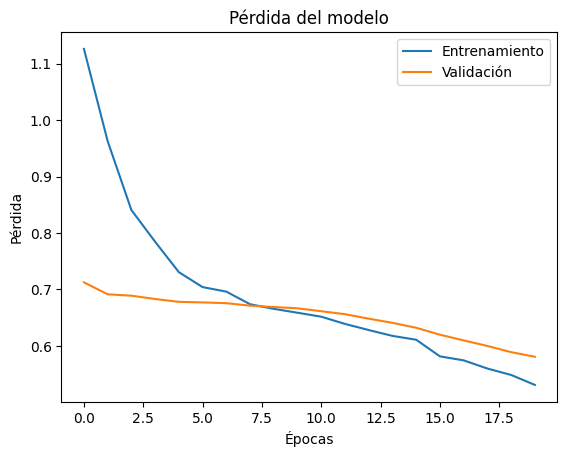

In [304]:
# Graficar pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()